# Fall 2024 - Final Project - GF180 MPW Shuttle Submission

## Verilog - Part 3

<b>Final Project Due (to Get on the Shuttle):</b> <font color="red"><b>12/11/24 at 6:00pm</b></font><br>
<b>Final Project Due (for course credit):</b> <font color="red"><b>12/17/24 at 6:00pm</b></font><br>

### Getting Started

<b>1) Open your PuTTY Terminal and Log into Cadence as normal</b>

    cd esc-courses/fa24-cse-30342.01/dropbox/
    tcsh
    source cadence_nd.sh
    cd VLSI/Verilog

<b>2) Test the success of your startup</b>

    which xrun

> /escnfs/home/csesoft/cadence/installs/XCELIUM1903/tools.lnx86/bin/xrun

## Controller

Let's study a Verilog description of a MIPS 8-bit Multicycle CPU 

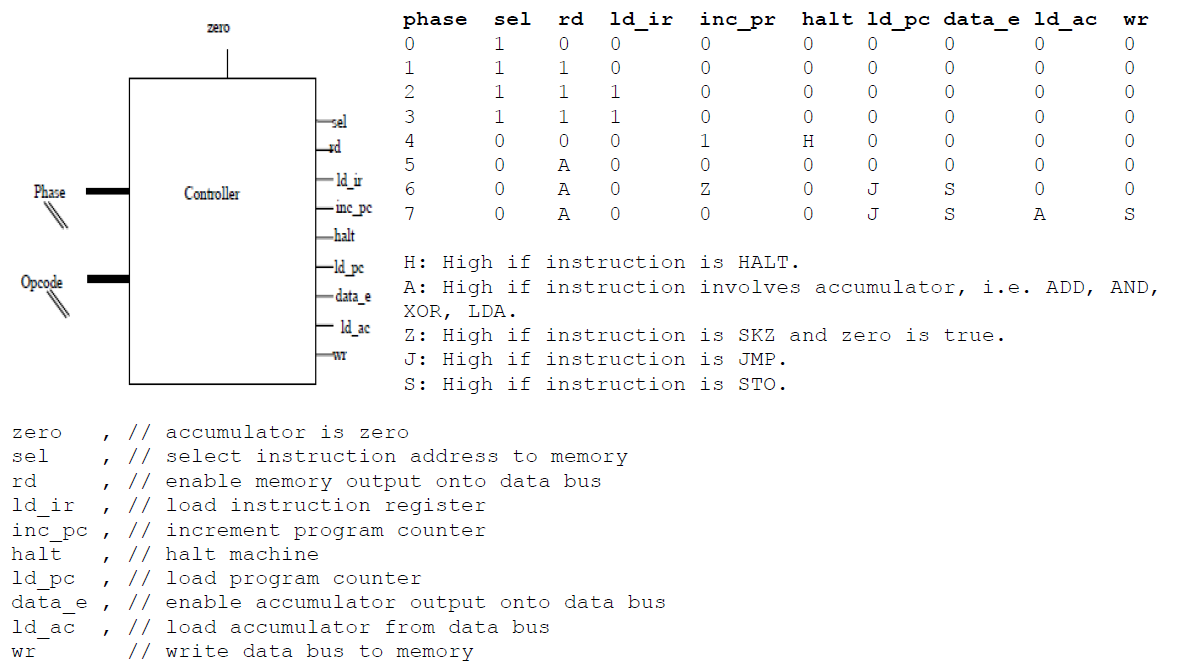

We will use a <code>reg</code> to save an intermediate output, similar to using a Flip-Flip to store intermediate stages.

    module controller
    (
      input  wire [2:0] opcode ,
      input  wire [2:0] phase  ,
      input  wire       zero   , // accumulator is zero
      output reg        sel    , // select instruction address to memory
      output reg        rd     , // enable memory output onto data bus
      output reg        ld_ir  , // load instruction register
      output reg        inc_pc , // increment program counter
      output reg        halt   , // halt machine
      output reg        ld_pc  , // load program counter
      output reg        data_e , // enable accumulator output onto data bus
      output reg        ld_ac  , // load accumulator from data bus
      output reg        wr       // write data bus to memory
    );

      localparam integer HLT=0, SKZ=1, ADD=2, AND=3, XOR=4, LDA=5, STO=6, JMP=7;

      reg H,A,Z,J,S;

      always @* begin
          H = (opcode == HLT);
          A = (opcode == ADD || opcode == AND || opcode == XOR || opcode == LDA);
          Z = (opcode == SKZ && zero);
          J = (opcode == JMP);
          S = (opcode == STO);
          case ( phase )
      0:begin sel=1;rd=0;ld_ir=0;inc_pc=0;halt=0;ld_pc=0;data_e=0;ld_ac=0;wr=0;end
      1:begin sel=1;rd=1;ld_ir=0;inc_pc=0;halt=0;ld_pc=0;data_e=0;ld_ac=0;wr=0;end
      2:begin sel=1;rd=1;ld_ir=1;inc_pc=0;halt=0;ld_pc=0;data_e=0;ld_ac=0;wr=0;end
      3:begin sel=1;rd=1;ld_ir=1;inc_pc=0;halt=0;ld_pc=0;data_e=0;ld_ac=0;wr=0;end
      4:begin sel=0;rd=0;ld_ir=0;inc_pc=1;halt=H;ld_pc=0;data_e=0;ld_ac=0;wr=0;end
      5:begin sel=0;rd=A;ld_ir=0;inc_pc=0;halt=0;ld_pc=0;data_e=0;ld_ac=0;wr=0;end
      6:begin sel=0;rd=A;ld_ir=0;inc_pc=Z;halt=0;ld_pc=J;data_e=S;ld_ac=0;wr=0;end
      7:begin sel=0;rd=A;ld_ir=0;inc_pc=0;halt=0;ld_pc=J;data_e=S;ld_ac=A;wr=S;end
          endcase
        end
    endmodule
    
To run and test:

    wget https://raw.githubusercontent.com/mmorri22/cse30342/main/lec39/controller.v
    wget https://raw.githubusercontent.com/mmorri22/cse30342/main/lec39/controller_test.v
    
    xrun controller.v controller_test.v

## Blocking Assignments in Sequential Procedures

A challenge: Blocking assignments can lead to race conditions, specifically when the same event triggers multiple procedures.

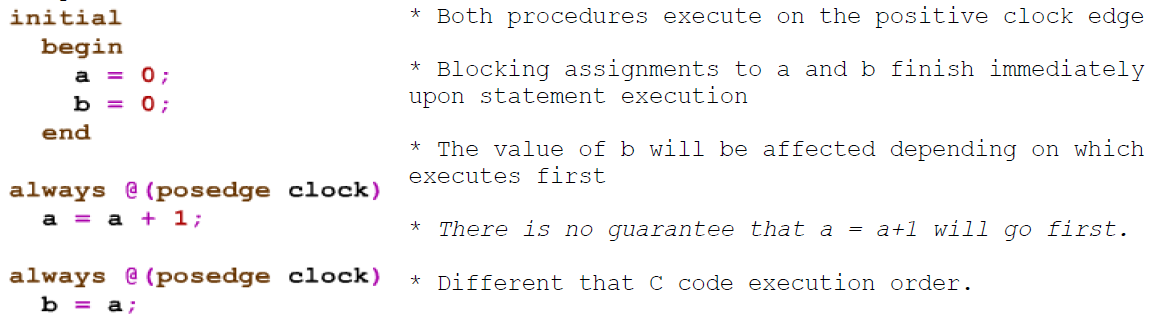

### The Blocking Assignment Order Affects Functionality

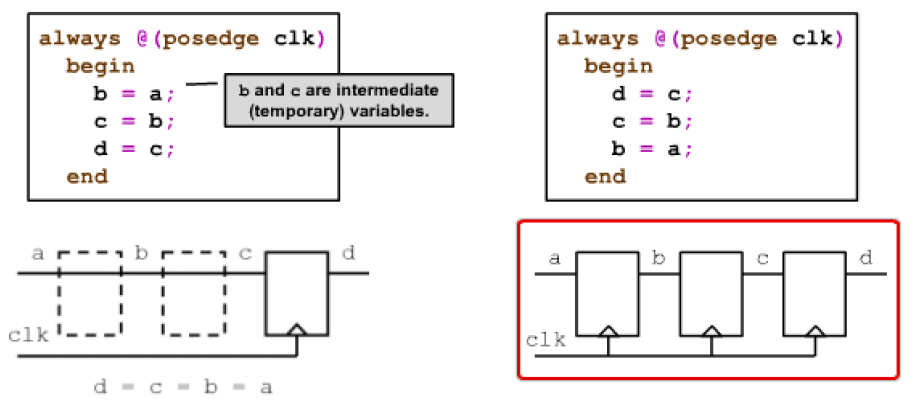

### Non-Blocking Statements

A nonblocking assignment schedules completion and does not block
• By default, completes when all executing blocks have been blocked

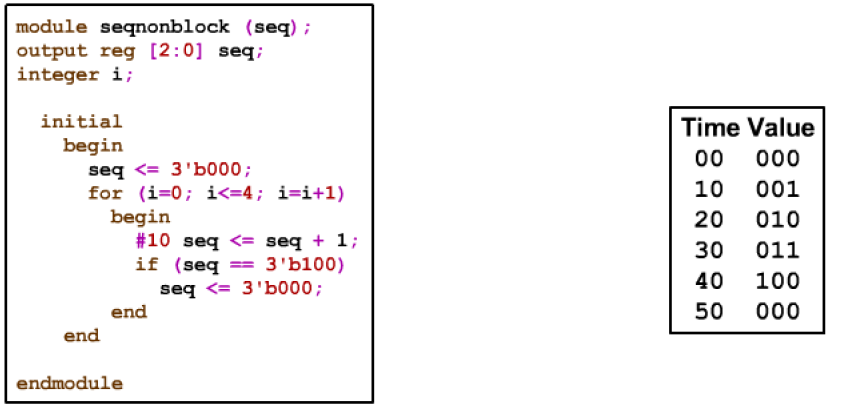

### We've already seen this!

Recall from our <a href = "https://raw.githubusercontent.com/mmorri22/cse30342/main/lec37/nand2_stim.v">nand2_stim.v</a> that we designed together:

    module nand2_Stim(A, B); 

        output A, B;

        parameter delay = 100; // Delay

        // Used for creating two-input binary test 
        reg [1:0] cnt;

        initial begin
            cnt = 0;
            // repeat (3) means do the function 4 times
            // Similar: for(i=0; i < 4; i++) 
            repeat (3) begin
                #delay cnt=cnt+1; /*** NON-BLOCKING STATEMENT *****/
            end
        end

        // Automaticaly convert 'cnt' this to binary
        // 0 -> A = '0', B = '0'
        // 1 -> A = '0', B = '1'... and so on. 
        assign {A,B} = cnt;

    endmodule
    
### Can Nonblocking Assignment Order Affect Functionality

Nonblocking Assignment order of appearance cannot affect functionality if:
<ul>
    <li>Statements are executed in the same simulation cycle</li>
    <li>Each target is assigned only once</li>
    <li>No target is assigned in any other procedural block</li>
    <li>No blocking assignments are mixed with the nonblocking assignments</li>
</ul>

## Example: A Register using Non-Blocking Statements

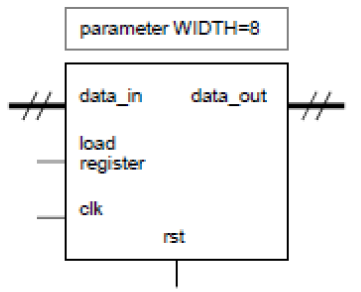

Start with the parameters:

    module register
    #(
        parameter integer WIDTH=8
    )
    (
        input wire clk ,
        input wire rst ,
        input wire load ,
        input wire [WIDTH-1:0] data_in,
        output reg [WIDTH-1:0] data_out
    );
    
We will define the positive edge clock to change the data_out to data_in. We also will reset where the output is 0. Otherwise, the output will stay the same:

    always @(posedge clk)
        if ( rst ) 
            data_out <= 0; 
        else if ( load ) 
            data_out <= data_in;
        else 
            data_out <= data_out;
    endmodule
    
To run the example:

    https://raw.githubusercontent.com/mmorri22/cse30342/refs/heads/main/lec39/register_test.v
    
    xrun register.v register_test.v

### Using Continuous & Procedural Assignments

Multiple Continuous assignments to a single net are “wired together”. 

#### Combinational Feedback Loops – Be Careful!

Zero-delay feedback loops may cause the simulator to appear to “lock up”
• The process never finished or suspends
• The simulator never gets to do anything else

Here is a short feedback loop deliberately generating a clock
• A continuous assignment is its own process. Whenever clk_out changes, the value is updated continuously

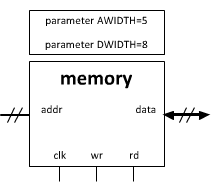

5-bit input gives a 32-bit output
In this case, the 5-bit input still has 32 memory elements, but is for an 8-bit register instead of a 32 bit register.

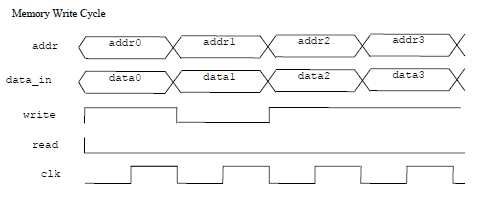

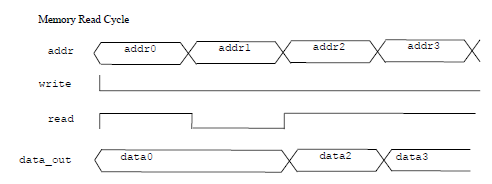

Perform the following commands:

    touch memory.v
    wget https://raw.githubusercontent.com/mmorri22/cse30342/refs/heads/main/lec39/memory_test.v

To perform the tests, we will do the following

    xrun memory.v memory_test.v

And to see the schematic tracer, we can perform the following:

    xrun -access +r -gui memory.v memory_test.v

## Building the Final Reduced Instruction Set Computer

This is the final RISC computer you will be designing and simulating. This puts all the pieces together.

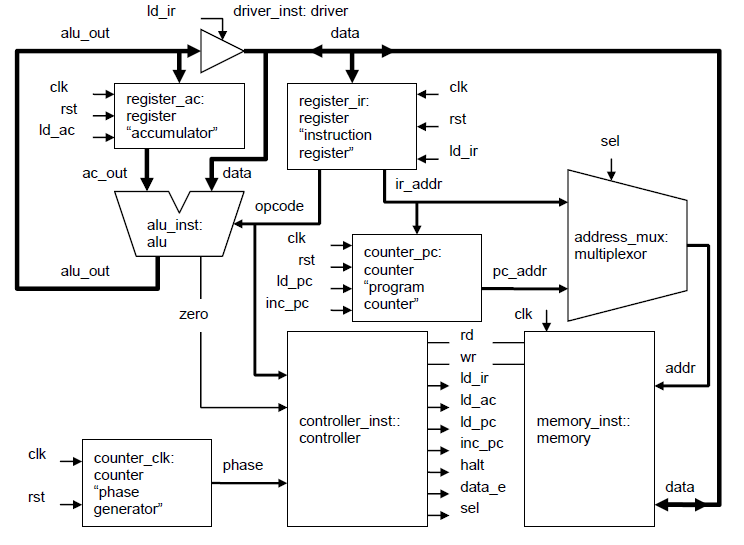


To obtain all the files, run the following command:

    mkdir risc
    cd risc

    wget https://raw.githubusercontent.com/mmorri22/cse30342/refs/heads/main/lec39/risc_setup.sh

    chmod +rx risc_setup.sh

    ./risc_setup.sh
    
You will download all the correct files for the alu, controller, memory, register, and driver code, as well as a file (files.txt) which will allow you to run irun with all the code:

    xrun -f files.txt
    
    xrun -access +r -gui -f files.txt